## TERM DEPOSIT MARKETING
In this project, various bank customer data such as age, job, marital status, education etc. are used to predict if a customer will subscribe to a term deposit account or not.   

Following are the attributes of the datset   
   
age : age of customer (numeric)   
job : type of job (categorical)   
marital : marital status (categorical)   
education (categorical)   
default: has credit in default? (binary)   
balance: average yearly balance, in euros (numeric)   
housing: has a housing loan? (binary)   
loan: has personal loan? (binary)   
contact: contact communication type (categorical)   
day: last contact day of the month (numeric)   
month: last contact month of year (categorical)   
duration: last contact duration, in seconds (numeric)   
campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)   
Output (desired target):   
   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import StratifiedKFold

In [2]:
df1 =  pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# A) Exploratory Data Analysis

In [4]:
df1.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


<AxesSubplot:xlabel='y', ylabel='count'>

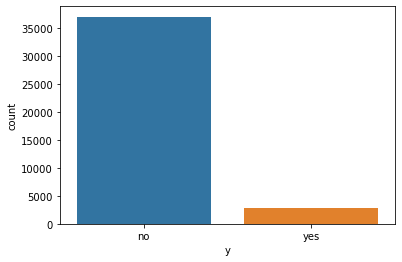

In [5]:
# The dataset is highly imbalanced. Less than 10 % are the 'yes' group (subscribed to a term deposit account)
# This is the group that is of interest to us. 
# That is, which customer characteristics will make him/her to subscribe to a term deposit account

sns.countplot(x='y', data=df1)

## Chi Square Test


Many of the features such as job, marital status, education have categorical values. One of the initial steps would be to determine if these features have any association to the outcome (i.e. said 'yes' or 'no' to a term deposit account subscription. Our null and alternate hypothesis are as follows;  
  
NULL HYPOTHESIS H0: Categorical variable tested is not a significant predictor of the outcome variable 'y'  
ALTERNATE HYPOTHESIS H1: Categorical variable tested is could be a significant predictor of the outcome variable 'y'  
  
We will use the Chi Square or the Goodness of Fit test to check the independence of these variables and a p value < 0.05 will be considered sufficient to reject the NULL HYPOTHESIS.

In [6]:
# The following function calculates the Chi Square p-value when comparing the categorical variable in list cat_var
# against the outcome variable 'y'  ('yes' or 'no')


cat_var = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'campaign']
def chi_sq (df):
    """
    INPUT : Dataframe containing categorical data for columns specified in cat_var
    The function calculates the Chi-Square p values when comparing between each of the variables and the output variable 'y'
    OUTPUT : a dataframe containing the p-values corresponding to each of the variables
    """
    p_Vals_dict = {}
    for feat in cat_var:
        cross_tab = pd.crosstab(df1[feat], df1['y'])
        chiVal, pVal,degfrdm, exp = chi2_contingency(cross_tab)
        p_Vals_dict[feat] = pVal
    
    p_Vals_df = pd.DataFrame(index = ['Job Type', 'Marital Status', 'Education Level', 'Default History', 
                                      'Housing Loan', 'Personal Loan', 'Contact Method', 'Last Contact Day', 
                                      'Last Contact Month', 'Number of Contacts'], 
                             data = p_Vals_dict.values(), columns = ['p-value'])
    return p_Vals_df
    

In [7]:
chi_sq(df1)

,p-value
Job Type,1.676135e-26
Marital Status,3.091031e-30
Education Level,8.061911e-21
Default History,2.137353e-01
Housing Loan,2.048343e-27
Personal Loan,6.395487e-10
Contact Method,7.242047e-71
Last Contact Day,4.733110e-70
Last Contact Month,0.000000e+00
Number of Contacts,5.174950e-06


With the exception of default history, the p value is less than 0.05 for all the categorical features tested. This indicates that, for those features, we can safely reject the null hypothesis. That is, these features are not a significant predictor of the choice of a customer to sign up for a term deposit account (or not). However, default history appears to be a predictor of a customers' choice (or the bank will not consider applications of customers with a history of default).

## Do any of the features make a customer more likely to subscribe to a term deposit account?

## 1) Comparing the normalized 'yes' and the 'no' groups for the categorical columns

In [9]:
# Define function to plot data in each of the categorical columns

def simple_compare(feature, ax=None):
    fracs = {} #define empty dictionary
    #loop through the unique values in the column
    for element in df1[feature].unique():
        # count the total customers who subscribed to the account
        yes_count = df1[df1['y']== 'yes'][feature].count()
        # count the total customers who did not subscribe to the account
        no_count = df1[df1['y']== 'no'][feature].count()
        # calculate the fraction of each unique value (eg. 'married') AND subscribed ('yes' group) 
        yes = df1[(df1[feature]== element) & (df1['y']=='yes')][feature].count()/yes_count
        # calculate the fraction of each unique value (eg. 'married') but DID NOT subscribe ('no' group) 
        no = df1[(df1[feature]== element) & (df1['y']=='no')][feature].count()/no_count
        #add fraction values to the dictionary
        fracs[feature+'_'+str(element)] = no,yes
    
    #create data frame from the disctionary of fractions and plot a barplot
    fracs_df = pd.DataFrame(index = df1[feature].unique(), data =  fracs.values(), columns = ['no','yes']) 
    fracs_df = fracs_df.transpose()
    fracs_df = fracs_df.melt(var_name=feature, value_name='fraction', ignore_index=False)
    sns.barplot(x=fracs_df.index, y= fracs_df.fraction, hue=fracs_df[feature])
        
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(feature)
    plt.xlabel('Account Subscription')

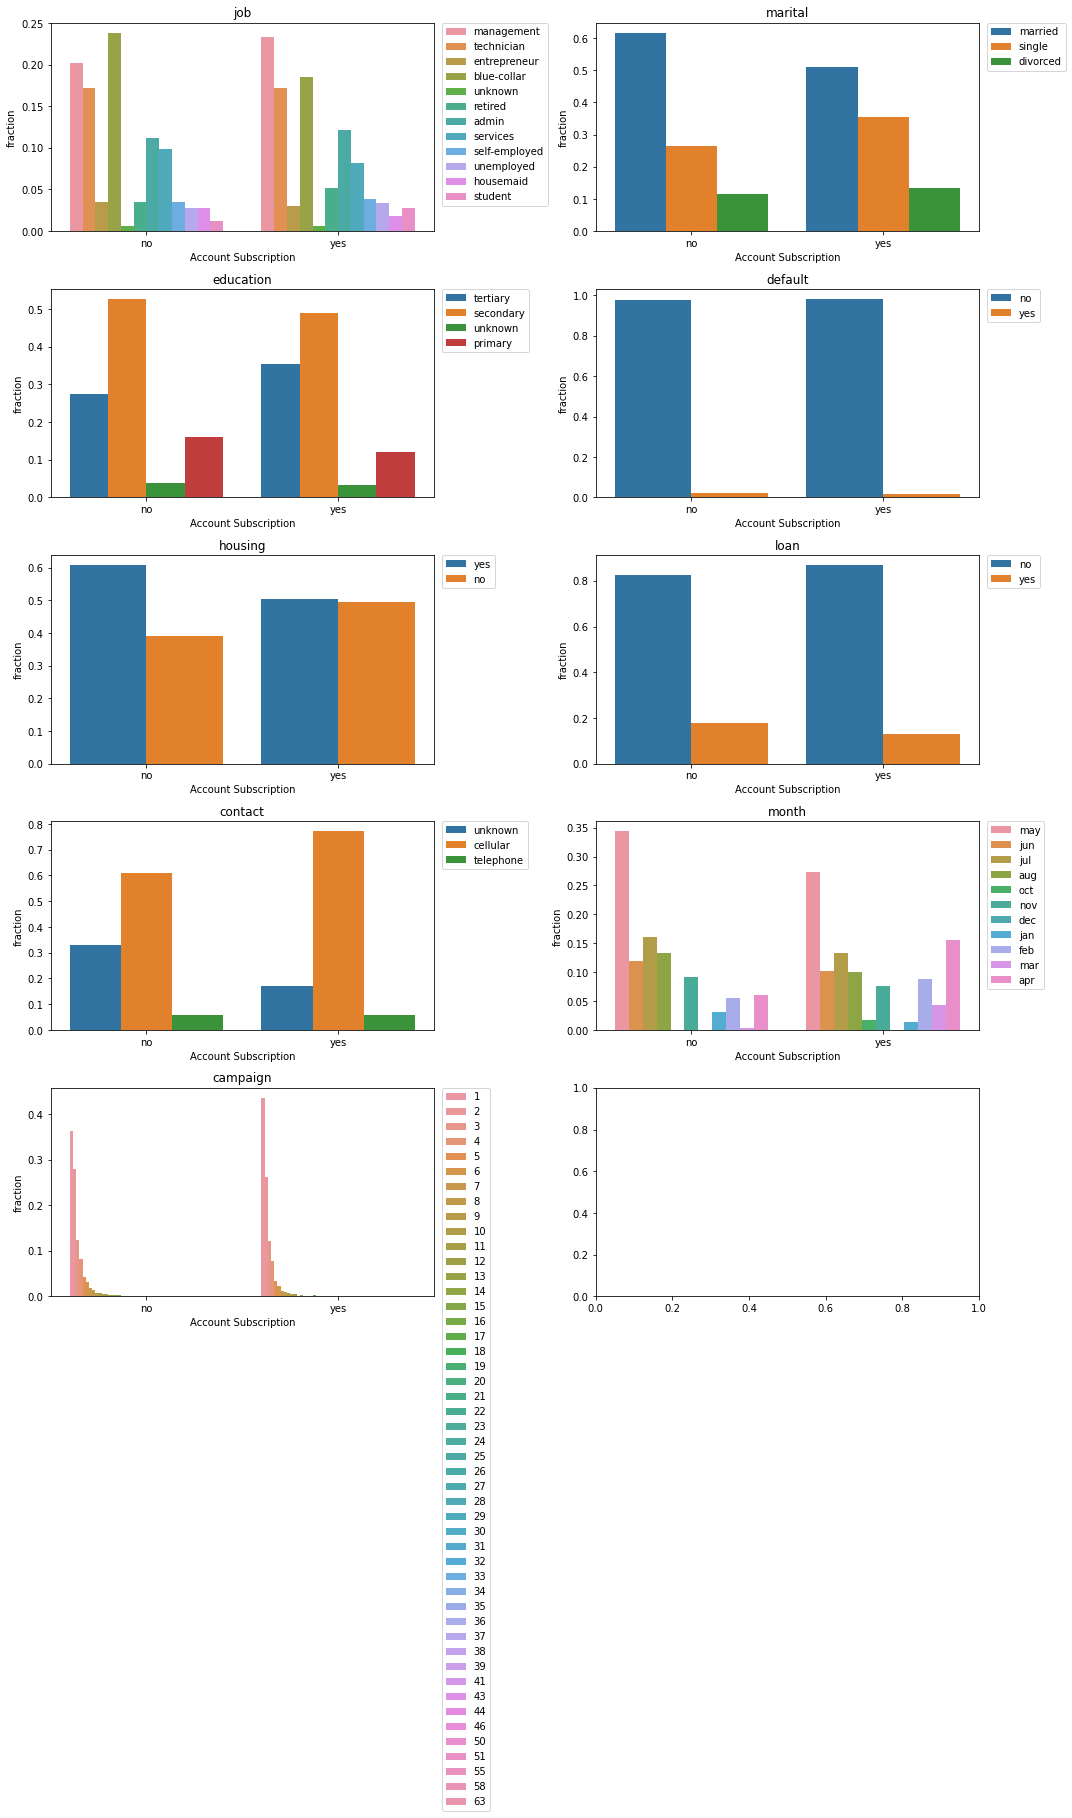

In [10]:
#plot each of the categorical column data in bar plots using the above simple_compare function.

cat_var = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign']

ind=1
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,25))
for feature in cat_var:
    axes = plt.subplot(5,2,ind)
    simple_compare(feature, ax=axes)
    ind+=1
plt.tight_layout()

The key points of the above plots are as follows;  
1) In the 'job' category, there is a slightly higher chance that students and those with management jobs will subscribe to term deposit accounts.  
2) In the 'marital' category, single people are slightly more likely to subscribe (but married people are less likely).  
3) In the 'education' category, those with tertiary education are slightly more likely to subscribe.  
4) In the 'default' category, there is no difference. Those with previous defaults are probably very unlikely to be even considered for an account subscription.  
5) In the 'housing' category, those without a housing loan are slightly more likely to subscribe (while those with a housing loan are slightly less likely to subscribe).  
6) In the 'loan' category, those without personal loans are only very slightly more likely to subscribe than those without.  
7) In the 'contact' category, those contacted via cellular phone are more likely to subscribe than via other means.  
8) In the 'month' category, those contacted during the months of February, March and April are slightly more likely to subscribe.  
9) In the 'campaign' category, one contact appears to be the most effective for those who are likely to subscribe.  

## 2) Comparing the continuous data in 'age', 'balance' and 'duration' columns
## a) Does a specific age group makes it more likely that a customer will subscribe to a term deposit account?

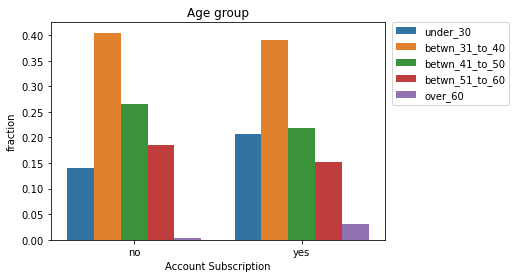

In [11]:
age_groups = {}

yes_count = df1[df1['y']== 'yes']['age'].count()
no_count = df1[df1['y']== 'no']['age'].count()

age_groups['under_30'] = df1[(df1['age']<=30) & (df1['y']== 'no')]['age'].count()/no_count,\
                         df1[(df1['age']<=30) & (df1['y']== 'yes')]['age'].count()/yes_count
    
age_groups['betwn_31_to_40'] = df1[(df1['age']>=31) & (df1['age']<=40) & (df1['y']== 'no')]['age'].count()/no_count ,\
                               df1[(df1['age']>=31) & (df1['age']<=40) & (df1['y']== 'yes')]['age'].count()/yes_count
    
age_groups['betwn_41_to_50'] = df1[(df1['age']>=41) & (df1['age']<=50) & (df1['y']== 'no')]['age'].count()/no_count ,\
                               df1[(df1['age']>=41) & (df1['age']<=50) & (df1['y']== 'yes')]['age'].count()/yes_count
    
age_groups['betwn_51_to_60'] = df1[(df1['age']>=51) & (df1['age']<=60) & (df1['y']== 'no')]['age'].count()/no_count , \
                               df1[(df1['age']>=51) & (df1['age']<=60) & (df1['y']== 'yes')]['age'].count()/yes_count
    
age_groups['over_60'] = df1[(df1['age']>60) & (df1['y']== 'no')]['age'].count()/no_count , \
                        df1[(df1['age']>60) & (df1['y']== 'yes')]['age'].count()/yes_count


age_gp_df = pd.DataFrame(index = age_groups.keys(), data =  age_groups.values(), columns = ['no','yes']) 
age_gp_df = age_gp_df.transpose()
age_gp_df = age_gp_df.melt(var_name='Age_group', value_name='fraction', ignore_index=False)
age_gp_df
sns.barplot(x=age_gp_df.index, y= age_gp_df.fraction, hue=age_gp_df['Age_group'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Age group')
plt.xlabel('Account Subscription')
plt.show()

It seems that those under 30 and over 60 years of age are more likely to subscribe to a term deposit account.
  
   
## b) Does a particular bank balance make it more likely that a customer will subscribe?

In [12]:
df1['balance'].describe() # minimum balance is about -$8000 and the maximum is over $100,000

count     40000.000000
mean       1274.277550
std        2903.769716
min       -8019.000000
25%          54.000000
50%         407.000000
75%        1319.000000
max      102127.000000
Name: balance, dtype: float64

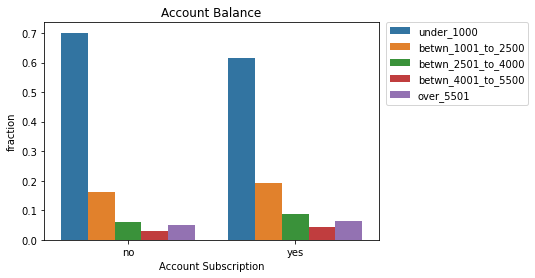

In [13]:
act_bal = {}


act_bal['under_1000'] = df1[(df1['balance']<=1000) & (df1['y']== 'no')]['balance'].count()/no_count,\
                         df1[(df1['balance']<=1000) & (df1['y']== 'yes')]['balance'].count()/yes_count
    
act_bal['betwn_1001_to_2500'] = df1[(df1['balance']>=1001) & (df1['balance']<=2500) & (df1['y']== 'no')]['balance'].count()/no_count ,\
                               df1[(df1['balance']>=1001) & (df1['balance']<=2500) & (df1['y']== 'yes')]['balance'].count()/yes_count
    
act_bal['betwn_2501_to_4000'] = df1[(df1['balance']>=2501) & (df1['balance']<=4000) & (df1['y']== 'no')]['balance'].count()/no_count ,\
                               df1[(df1['balance']>=2501) & (df1['balance']<=4000) & (df1['y']== 'yes')]['balance'].count()/yes_count
    
act_bal['betwn_4001_to_5500'] = df1[(df1['balance']>=4001) & (df1['balance']<=5500) & (df1['y']== 'no')]['balance'].count()/no_count , \
                               df1[(df1['balance']>=4001) & (df1['balance']<=5500) & (df1['y']== 'yes')]['balance'].count()/yes_count
    
act_bal['over_5501'] = df1[(df1['balance']>5501) & (df1['y']== 'no')]['balance'].count()/no_count , \
                        df1[(df1['balance']>5501) & (df1['y']== 'yes')]['balance'].count()/yes_count
act_bal_df = pd.DataFrame(index = act_bal.keys(), data =  act_bal.values(), columns = ['no','yes']) 
act_bal_df = act_bal_df.transpose()
act_bal_df = act_bal_df.melt(var_name='Act_balance', value_name='fraction', ignore_index=False)
act_bal_df
sns.barplot(x=act_bal_df.index, y= act_bal_df.fraction, hue=act_bal_df['Act_balance'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Account Balance')
plt.xlabel('Account Subscription')
plt.show()


Customers with bank balances under $1000 are less likely but those with balances over $1000 are more likely to subscribe.  

## c) What kind of contact duration makes it more likely that a customer will subscribe?

In [14]:
df1['duration'].describe() # minimum duration is 0 seconds and the maximum is close to 5000 seconds

count    40000.000000
mean       254.824300
std        259.366498
min          0.000000
25%        100.000000
50%        175.000000
75%        313.000000
max       4918.000000
Name: duration, dtype: float64

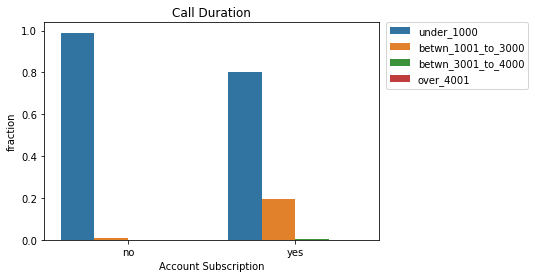

In [15]:
call_dur = {}


call_dur['under_1000'] = df1[(df1['duration']<=1000) & (df1['y']== 'no')]['duration'].count()/no_count,\
                         df1[(df1['duration']<=1000) & (df1['y']== 'yes')]['duration'].count()/yes_count
    
call_dur['betwn_1001_to_3000'] = df1[(df1['duration']>=1001) & (df1['duration']<=3000) & (df1['y']== 'no')]['duration'].count()/no_count ,\
                               df1[(df1['duration']>=1001) & (df1['duration']<=3000) & (df1['y']== 'yes')]['duration'].count()/yes_count
    
call_dur['betwn_3001_to_4000'] = df1[(df1['duration']>=3001) & (df1['duration']<=4000) & (df1['y']== 'no')]['duration'].count()/no_count ,\
                               df1[(df1['duration']>=3001) & (df1['duration']<=4000) & (df1['y']== 'yes')]['duration'].count()/yes_count
    
call_dur['over_4001'] = df1[(df1['duration']>5501) & (df1['y']== 'no')]['duration'].count()/no_count , \
                        df1[(df1['duration']>5501) & (df1['y']== 'yes')]['duration'].count()/yes_count

call_dur_df = pd.DataFrame(index = call_dur.keys(), data =  call_dur.values(), columns = ['no','yes']) 
call_dur_df = call_dur_df.transpose()
call_dur_df = call_dur_df.melt(var_name='Call_duration', value_name='fraction', ignore_index=False)

sns.barplot(x=call_dur_df.index, y= call_dur_df.fraction, hue=call_dur_df['Call_duration'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Call Duration')
plt.xlabel('Account Subscription')
plt.show()

Contact duration of between 1000 to 3000 seconds increased the chances that a customer will subscribe.

## 4) Can multiple features (e.g. age under 30 yrs and single) help predict if a customer will subscribe to a term deposit account or not?

## a) Compare age (< 30 yrs or >60 yrs) with the categorical columns

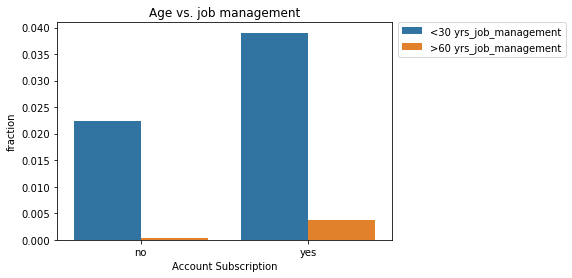

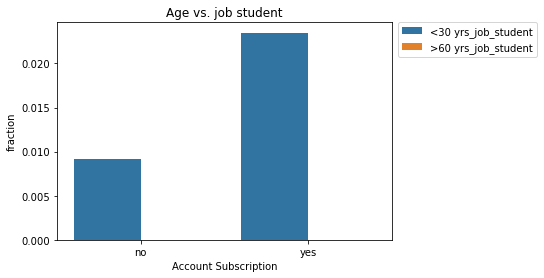

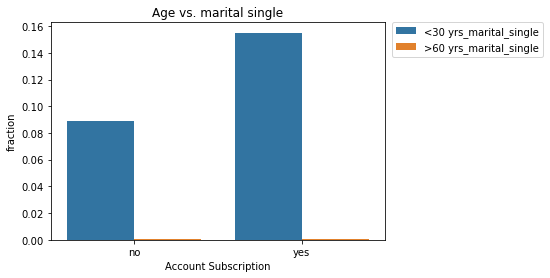

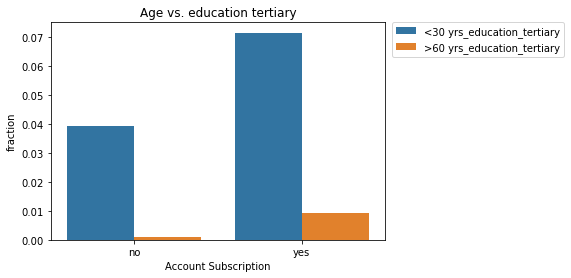

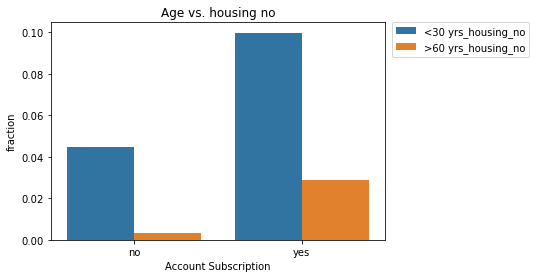

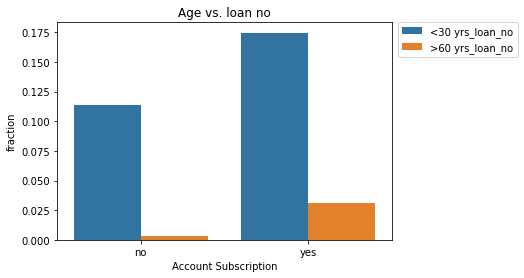

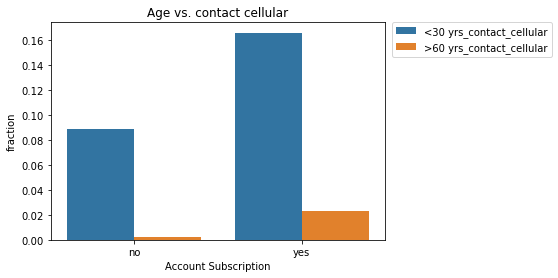

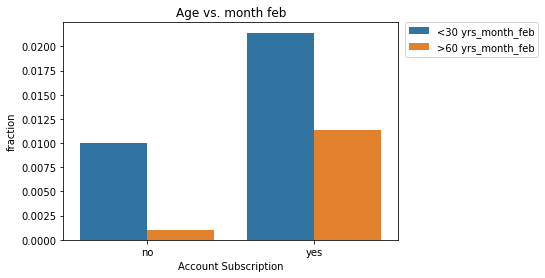

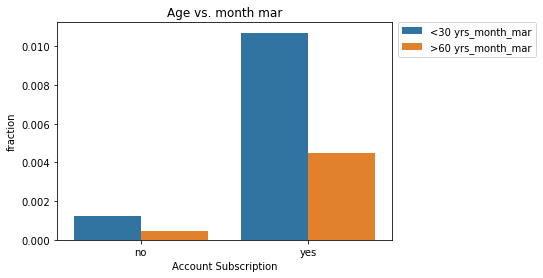

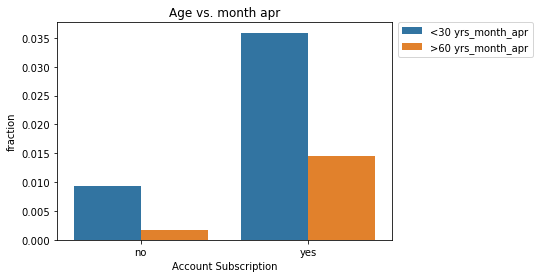

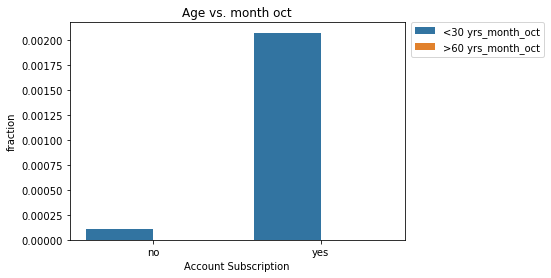

In [16]:
# create a dictionary for the categorical variable where specific underlying data indicated a higher chance of account 
# subscription (see above).

catvar = {'job':('management', 'student'), 'marital':('single',), 'education':('tertiary',), 'housing':('no',), 
         'loan':('no',), 'contact':('cellular',), 'month':('feb', 'mar', 'apr', 'oct')}

yes_count = df1[df1['y']== 'yes']['age'].count()
no_count = df1[df1['y']== 'no']['age'].count()




for key, value in catvar.items():
    
    for val in value:
        
        age_vs_cat = {}
        age_vs_cat['<30 yrs'+'_'+key+'_'+str(val)] = df1[(df1['age']<=30) & (df1[key]==val) & (df1['y']== 'no')]['age'].count()/no_count,\
                                                df1[(df1['age']<=30) & (df1[key]==val) & (df1['y']== 'yes')]['age'].count()/yes_count
        
        age_vs_cat['>60 yrs'+'_'+key+'_'+str(val)] = df1[(df1['age']>60) & (df1[key]==val) & (df1['y']== 'no')]['age'].count()/no_count , \
                                                 df1[(df1['age']>60) & (df1[key]==val) & (df1['y']== 'yes')]['age'].count()/yes_count
        
        
        age_vs_cat_df = pd.DataFrame(index = age_vs_cat.keys(), data =  age_vs_cat.values(), columns = ['no','yes']) 
        age_vs_cat_df = age_vs_cat_df.transpose()
        age_vs_cat_df = age_vs_cat_df.melt(var_name='Age', value_name='fraction', ignore_index=False)
        
        
        
        sns.barplot(x=age_vs_cat_df.index, y= age_vs_cat_df.fraction, hue=age_vs_cat_df['Age'])
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title('Age'+' '+'vs.'+' '+key+' '+val)
        plt.xlabel('Account Subscription')
        
        
        plt.show()
        
    

There is a clear indication that a younger age is a good predictive factor for subscribing to a term deposit account. So is being over 60 years of age is also a predictive factor though not in the student category (very few people over 60 would consider themselves students) or single category. Surprisingly, contact made during the month of October is an excellent predictor for enrolling those under 30 but not those over 60 years of age.

## b) Compare account balance over $1000 with the categorical columns

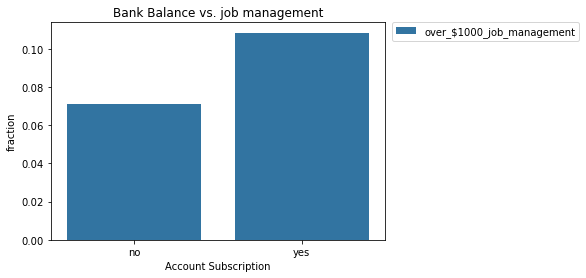

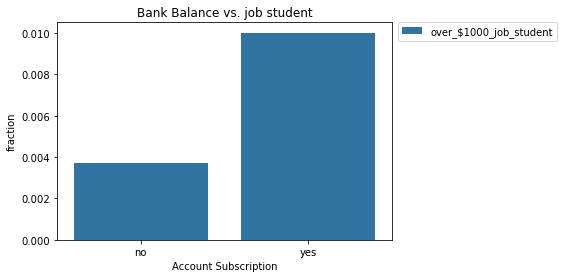

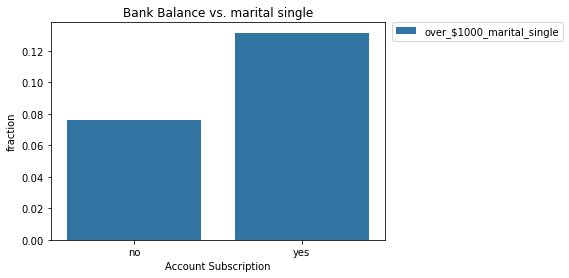

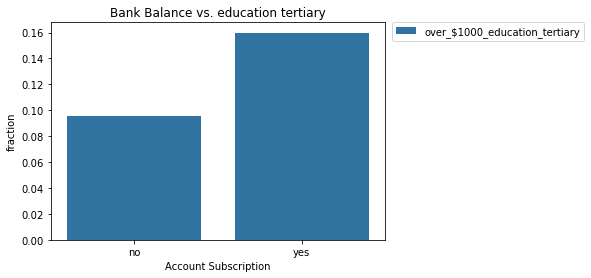

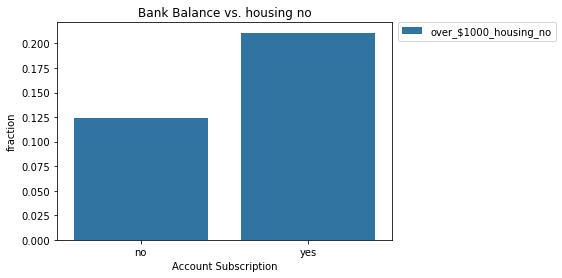

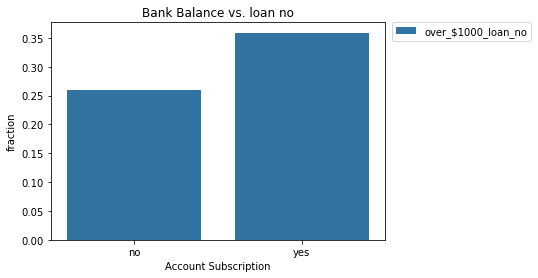

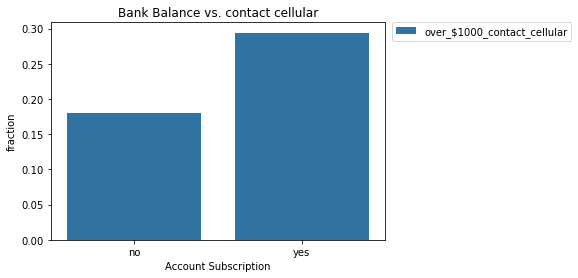

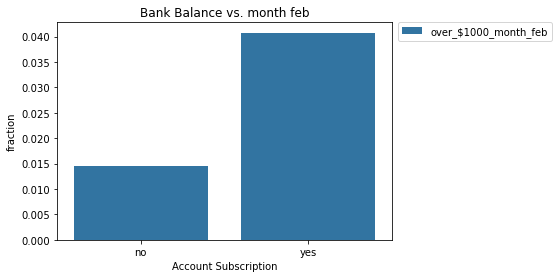

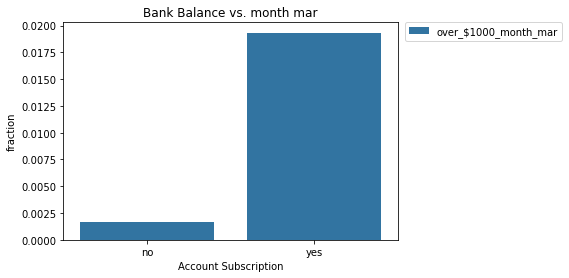

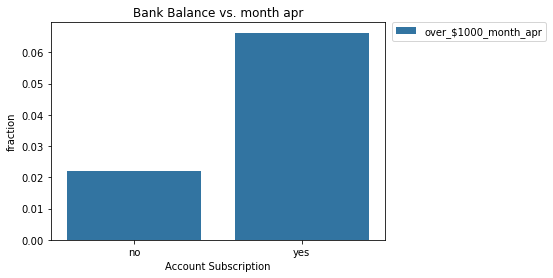

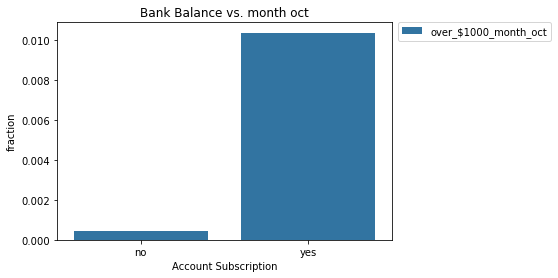

In [17]:
for key, value in catvar.items():
    
    for val in value:
        
        actbal = {}
        actbal['over_$1000'+'_'+key+'_'+str(val)] = df1[(df1['balance']>=1000) & (df1[key]==val) & (df1['y']== 'no')]['balance'].count()/no_count , \
                                                   df1[(df1['balance']>=1000) & (df1[key]==val) & (df1['y']== 'yes')]['balance'].count()/yes_count
        
        
        actbal_df = pd.DataFrame(index = actbal.keys(), data =  actbal.values(), columns = ['no','yes']) 
        actbal_df = actbal_df.transpose()
        actbal_df = actbal_df.melt(var_name='BankBal', value_name='fraction', ignore_index=False)
        
        
        
        sns.barplot(x=actbal_df.index, y= actbal_df.fraction, hue=actbal_df['BankBal'])
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title('Bank Balance'+' '+'vs.'+' '+key+' '+val)
        plt.xlabel('Account Subscription')
        
        
        plt.show()

A bank balance over $1000 is also a very good predictor of subscribing to a term deposit account when combined with all the other categories.

## c) Compare contact duration (1000 - 3000 seconds) with the categorical columns

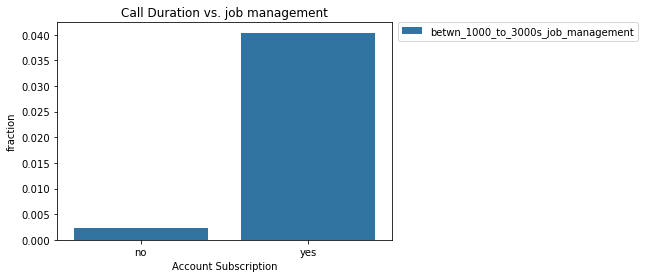

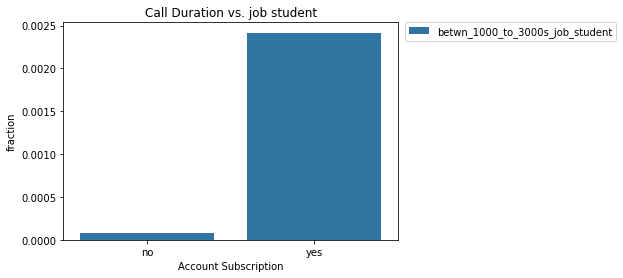

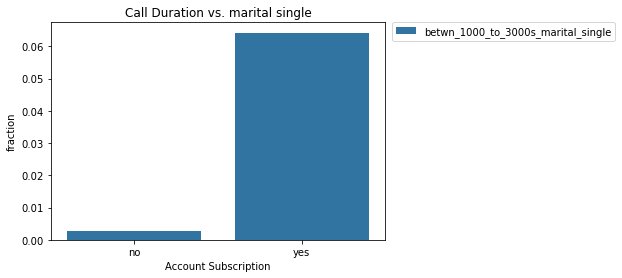

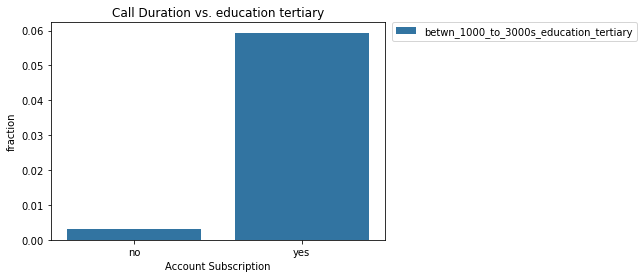

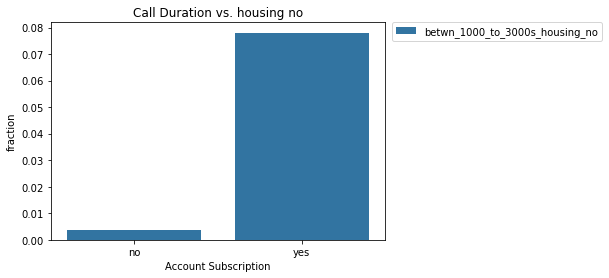

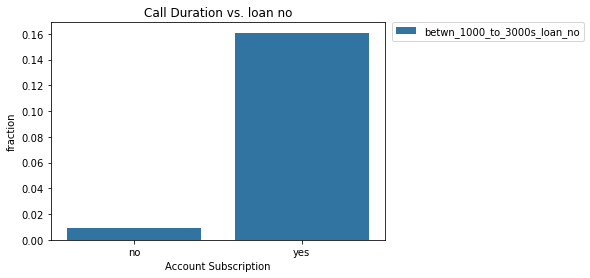

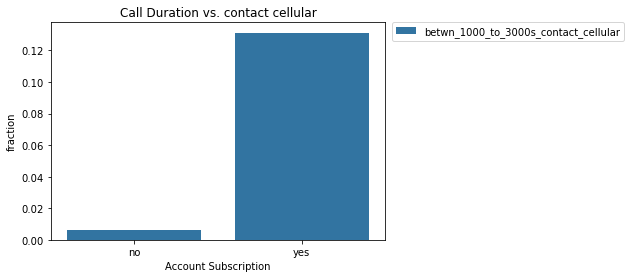

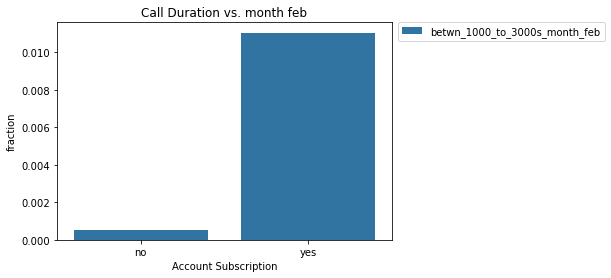

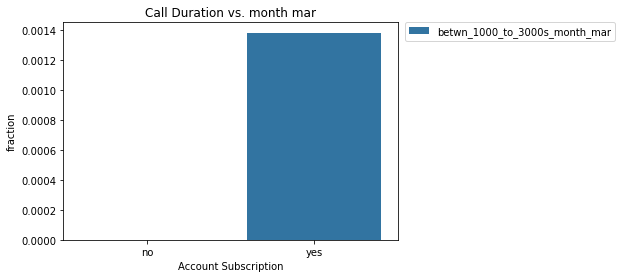

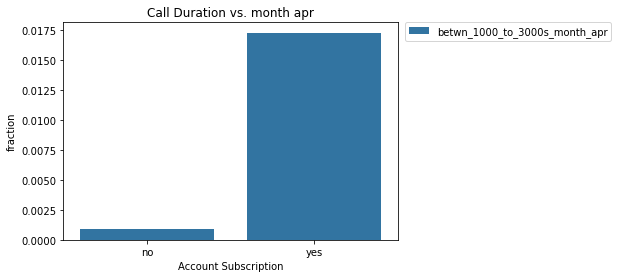

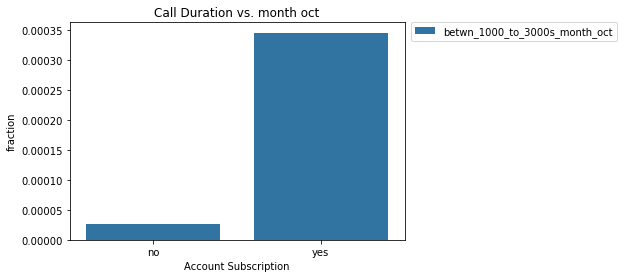

In [26]:
for key, value in catvar.items():
    
    for val in value:
        calldur = {}
        
        calldur['betwn_1000_to_3000s'+'_'+key+'_'+str(val)] = df1[(df1['duration']>=1000) & (df1['duration']<=3000) &  (df1[key]==val) & (df1['y']== 'no')]['duration'].count()/no_count ,\
                               df1[(df1['duration']>=1000) & (df1['duration']<=3000) &  (df1[key]==val) & (df1['y']== 'yes')]['duration'].count()/yes_count
        
        calldur_df = pd.DataFrame(index = calldur.keys(), data =  calldur.values(), columns = ['no','yes']) 
        calldur_df = calldur_df.transpose()
        calldur_df = calldur_df.melt(var_name='CallDur', value_name='fraction', ignore_index=False)

        
        sns.barplot(x=calldur_df.index, y= calldur_df.fraction, hue=calldur_df['CallDur'])
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title('Call Duration'+' '+'vs.'+' '+key+' '+val)
        plt.xlabel('Account Subscription')
        
        
        plt.show()

A call duration lasting 1000 -  3000 seconds (16 - 50 minutes) increases the chances that a customer will subscribe to an account

# Concluding remarks from Exploratory Data Analysis
1) Customers under 30 years or over 60 years of age are likely to subscribe.  
2) Customers with over $1000 in the bank are likely to subscribe  
3) A long call duration (between 16 to 50 minutes) increases the chances that a customer will subscribe.  
4) Combining the above with the following factors may increase the likelihood even further:  
        a) Having a management job or being a student  
        b) Being single  
        c) No housing loans   
        d) Contacted via cellphone for marketing the term deposit account   
        e) Contacted during the months of February, March, April or October  

# B) Data cleaning/ preparation for analysis

## Examine correlations between the columns with continuous data

<AxesSubplot:>

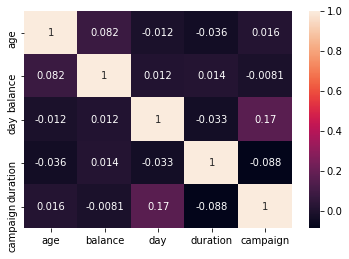

In [29]:
data_corr = df1.corr()
sns.heatmap(data_corr, annot=True)

The columns with continuous data are neither strongly negatively or positively correlated.

## Feature Engineering
Convert the categorical variables with text into dummy variables.

In [30]:
# make a deep copy of df1
df2 = df1.copy()

In [31]:
# replace all 'no's with 0 and 'yes' with 1 in the whole dataframe
df2.replace({'no':0, 'yes':1}, inplace = True)

In [32]:
# DROP the 'default' column since it is highly correlated with the outcome variable
# DROP the 'day' column since it likely has no useful information for model predictions
df2.drop(['default', 'day'], axis=1,inplace=True)

In [33]:
df2.head()

,age,job,marital,education,balance,housing,loan,contact,month,duration,campaign,y
0,58,management,married,tertiary,2143,1,0,unknown,may,261,1,0
1,44,technician,single,secondary,29,1,0,unknown,may,151,1,0
2,33,entrepreneur,married,secondary,2,1,1,unknown,may,76,1,0
3,47,blue-collar,married,unknown,1506,1,0,unknown,may,92,1,0
4,33,unknown,single,unknown,1,0,0,unknown,may,198,1,0


In [34]:
#create dummy columns for the following columns, and drop the first of the dummy columns
# DROP the 'day'
df3 = pd.get_dummies(df2, columns=['job','marital','month','education','contact'], drop_first=True)

In [35]:
df3.head()

,age,balance,housing,loan,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58,2143,1,0,261,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,44,29,1,0,151,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,33,2,1,1,76,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
3,47,1506,1,0,92,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
4,33,1,0,0,198,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [36]:
# specify dependent and independent variables
X = df3.drop('y', axis=1)
y = df3['y']

## Define function to conduct stratified K-fold validation

In [54]:
#create an instance of Stratified K Fold with 5 splits
def K_fold_validation (X ,y, mod):
    skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
    
    if mod == 'RFC':
        model = RandomForestClassifier(n_estimators = 200, max_depth = 3)
    elif mod == 'XGB':
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.5, max_depth=5)
    elif mod == 'LR':
        model = LogisticRegression(max_iter=5000, C=1) 
    
    score_dict = {}
    
    train_accuracy = []
    test_accuracy = []
    precision_gp0 = []
    precision_gp1 = []
    recall_gp0 = []
    recall_gp1 = []
    f1_gp0 = []
    f1_gp1 = []
    for train_index, test_index in skf.split(X, y):
        X_train = X.loc[train_index].values
        y_train = y.loc[train_index].values
        X_test = X.loc[test_index].values
        y_test = y.loc[test_index].values
        
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_accuracy.append(accuracy_score(y_train, train_pred))
        test_accuracy.append(accuracy_score(y_test, test_pred))
        precision_gp0.append(precision_score(y_test, test_pred, average=None)[0])
        precision_gp1.append(precision_score(y_test, test_pred, average=None)[1])
        recall_gp0.append(recall_score(y_test, test_pred, average=None)[0])
        recall_gp1.append(recall_score(y_test, test_pred, average=None)[1])
        f1_gp0.append(f1_score(y_test, test_pred, average=None)[0])
        f1_gp1.append(f1_score(y_test, test_pred, average=None)[1])
        
    score_dict['Train Accuracy'] = np.mean(train_accuracy)
    score_dict['Test Accuracy'] = np.mean(test_accuracy)
    score_dict['Precision GP 0'] = np.mean(precision_gp0)
    score_dict['Precision GP 1'] = np.mean(precision_gp1)
    score_dict['Recall GP 0'] = np.mean(recall_gp0)
    score_dict['Recall GP 1'] = np.mean(recall_gp1)
    score_dict['F1 Sore GP 0'] = np.mean(f1_gp0)
    score_dict['F1 Sore GP 1'] = np.mean(f1_gp1)

    df_metrics=pd.DataFrame(score_dict.items(), columns=['', 'score'])
    
    if mod == 'LR':
        model_imp = 0
    else: model_imp = pd.DataFrame({'Feature':X.columns, 'Importance':model.feature_importances_}).sort_values(by='Importance', ascending=False)
       
    return df_metrics.set_index(''), model_imp

In [48]:
unbalanced_data, model_imp = K_fold_validation(X, y, 'XGB')
unbalanced_data

,score
,
Train Accuracy,0.968731
Test Accuracy,0.932750
Precision GP 0,0.952628
Precision GP 1,0.552091
Recall GP 0,0.976040
Recall GP 1,0.378102
F1 Sore GP 0,0.964190
F1 Sore GP 1,0.448562


In [49]:
model_imp

,Feature,Importance
25,month_mar,0.110955
24,month_jun,0.083089
28,month_oct,0.075668
4,duration,0.073965
33,contact_unknown,0.066837
23,month_jul,0.050155
22,month_jan,0.047534
27,month_nov,0.040898
19,month_aug,0.038966
21,month_feb,0.032426


In [51]:
unbalanced_data, model_imp = K_fold_validation(X, y, 'RFC')
unbalanced_data

C:\Users\Manj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

,score
,
Train Accuracy,0.92760
Test Accuracy,0.92760
Precision GP 0,0.92760
Precision GP 1,0.00000
Recall GP 0,1.00000
Recall GP 1,0.00000
F1 Sore GP 0,0.96244
F1 Sore GP 1,0.00000


In [52]:
model_imp

,Feature,Importance
4,duration,0.498799
25,month_mar,0.123036
0,age,0.109728
33,contact_unknown,0.063706
28,month_oct,0.054886
1,balance,0.027545
2,housing,0.023301
17,marital_married,0.019765
5,campaign,0.014805
30,education_tertiary,0.012708


In [56]:
unbalanced_data, model_imp = K_fold_validation(X, y, 'LR')
unbalanced_data

,score
,
Train Accuracy,0.934562
Test Accuracy,0.934400
Precision GP 0,0.945364
Precision GP 1,0.605584
Recall GP 0,0.986282
Recall GP 1,0.269679
F1 Sore GP 0,0.965389
F1 Sore GP 1,0.373048
